# Imports:

In [2]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

# --- Standard Library Imports ---
import os
import joblib
from PIL import Image, ImageOps

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import torch

# --- Custom Imports ---
from src.utils import (
    extractCoordinates, aspect_crop, haversine_distance,
    plot_images_from_dataloader, setup_TensorBoard_writers,
    log_error_map, create_interactive_heatmap
)
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3, MultiTaskDINOGeo

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image preprocessing:

In [3]:
# Setup paths
RAW_IMAGE_FOLDER = r"data_manual_gps_united"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed_manual_gps" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1475:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [4]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

## Clustering for multi-task training:

Generating Zone Labels on Normalized Data...


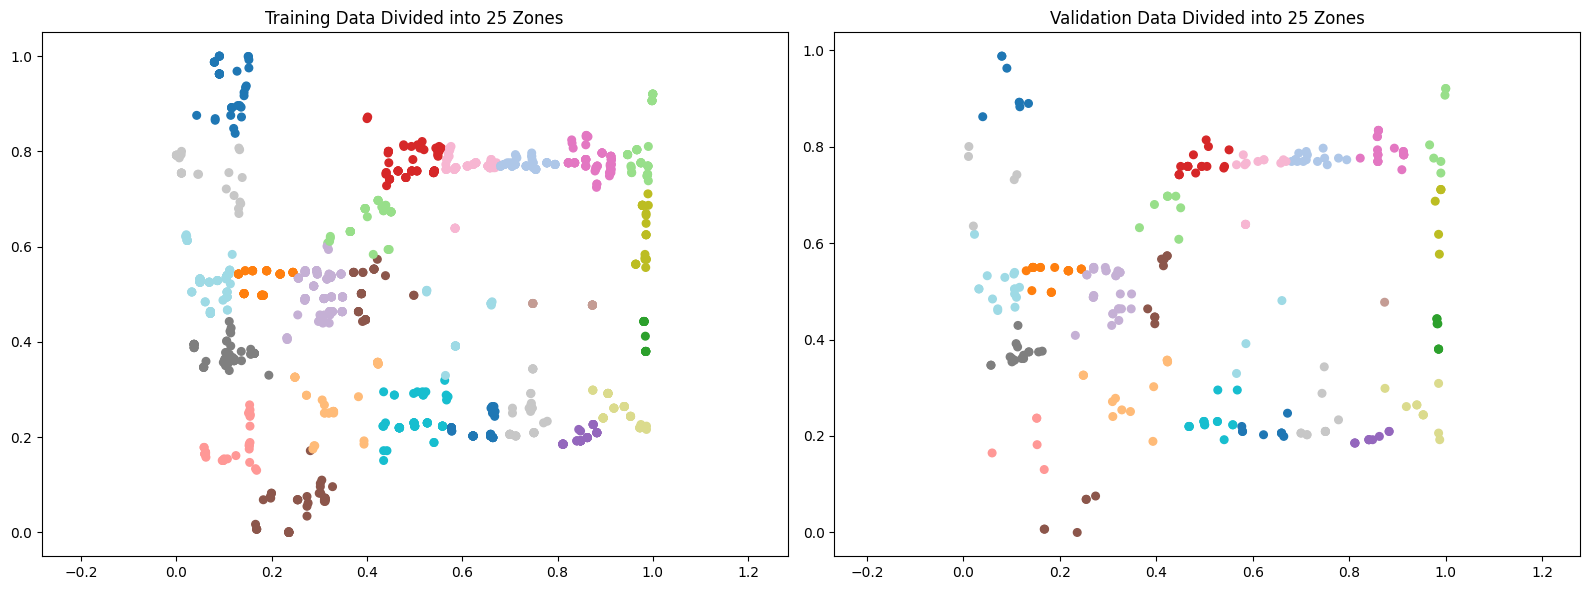

In [12]:
from sklearn.cluster import KMeans

print("Generating Zone Labels on Normalized Data...")

NUM_ZONES = 25 

kmeans = KMeans(n_clusters=NUM_ZONES, random_state=42, n_init=10)

# Fit on the normalized coordinates
train_df['zone_label'] = kmeans.fit_predict(train_df[['lat', 'lon']])
val_df['zone_label'] = kmeans.predict(val_df[['lat', 'lon']])

# plot the zones to see if they look reasonable for both training and validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data plot
axes[0].scatter(train_df['lon'], train_df['lat'], c=train_df['zone_label'], cmap='tab20', s=30)
axes[0].set_title(f"Training Data Divided into {NUM_ZONES} Zones")
axes[0].axis('equal')  # Keep aspect ratio so it looks like a map

# Validation data plot
axes[1].scatter(val_df['lon'], val_df['lat'], c=val_df['zone_label'], cmap='tab20', s=30)
axes[1].set_title(f"Validation Data Divided into {NUM_ZONES} Zones")
axes[1].axis('equal')  # Keep aspect ratio so it looks like a map

plt.tight_layout()
plt.show()

# Plot heatmap based on training data

In [ ]:
train_coords = scaler.inverse_transform(train_df[['lat', 'lon']].values)
create_interactive_heatmap(train_coords, output_file='train_data_heatmap.html')

Heatmap saved to train_data_heatmap.html


Initializing train dataset...
Caching 1180 images in RAM...


100%|██████████| 1180/1180 [00:03<00:00, 366.90it/s]


Initializing validation dataset...
Caching 295 images in RAM...


100%|██████████| 295/295 [00:01<00:00, 267.93it/s]


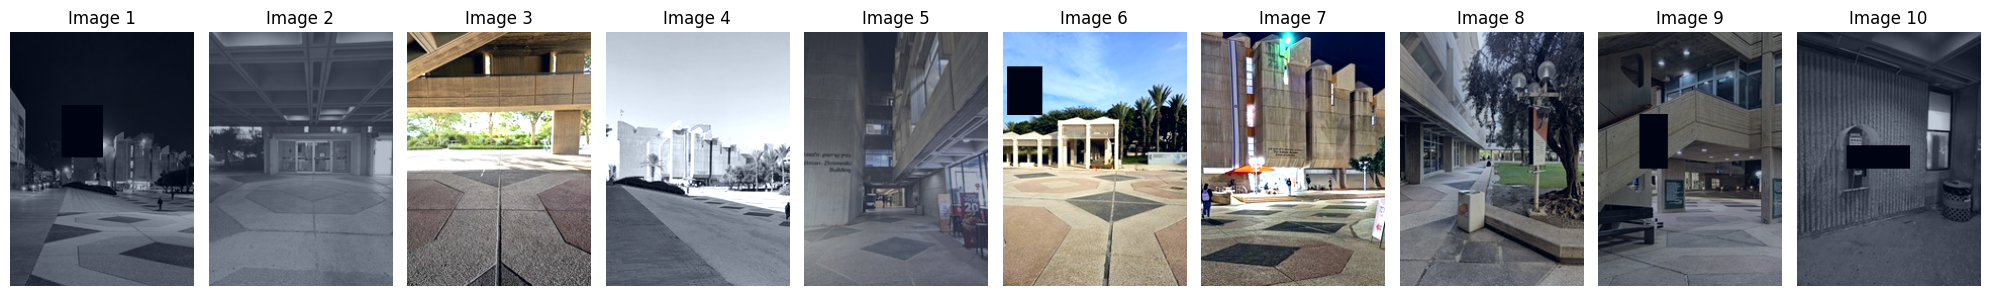

In [16]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        zone_labels=train_df['zone_label'].values,
        is_train=True,
        target_size=(252, 182)
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        zone_labels=val_df['zone_label'].values,
        is_train=False,
        target_size=(252, 182)
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=0, 
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=0, 
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [44]:
# --- 6. INITIALIZE MODEL ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = MultiTaskDINOGeo(NUM_ZONES).to(device)

if is_rtx:
    model = model.to(
        memory_format=torch.channels_last
    )  # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# --- 7. LOSS & OPTIMIZER ---
UNFREEZE_INTERVAL = 20  # epochs between unfreezing backbone blocks
patience_counter = 0
# stop early if no improvement before next unfreeze
early_stopping_patience = UNFREEZE_INTERVAL - 1
epochs = 500
use_TensorBoard = True  # Set to False to disable TensorBoard logging

criterion_reg = torch.nn.HuberLoss(delta=1.0)
criterion_cls = torch.nn.CrossEntropyLoss(label_smoothing=0.15)

base_head_lr = 1e-3
backbone_lr = 5e-5

victory_lap_started = False
victory_backbone_lr = 1e-5  
victory_head_lr = 5e-4  

optimizer = torch.optim.AdamW(
    [
        {
            "params": filter(lambda p: p.requires_grad, model.backbone.parameters()),
            "lr": backbone_lr,
        },
        {"params": model.shared.parameters(), "lr": base_head_lr},
        {"params": model.reg_head.parameters(), "lr": base_head_lr},
        {"params": model.cls_head.parameters(), "lr": base_head_lr},
    ],
    weight_decay=0.01,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=UNFREEZE_INTERVAL, T_mult=1, eta_min=1e-7
)

print(
    f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images."
)

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070


Using cache found in C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main


RTX card not detected: Disabling AMP/Channels_Last optimizations
Training on 1180 images, Validating on 295 images.


# Model training:

In [45]:
# --- 8. TRAINING & VALIDATION LOOP ---
train_losses = []
val_losses = []
val_avg_dist_history = []
val_median_dist_history = []
val_zone_accuracy = []
learning_rates = []
best_dist = float("inf")

if use_TensorBoard:
    writer_train, writer_val = setup_TensorBoard_writers()

print(f"Starting training on {device}...")

gradScaler = GradScaler(
    "cuda"
)  # scaler for mixed precision training, prevents gradient underflow

for epoch in range(epochs):
    # Check for Unfreezing layer blocks
    if epoch > 0 and epoch % UNFREEZE_INTERVAL == 0 and not victory_lap_started:

        did_unfreeze = model.unfreeze_step(epoch, interval=UNFREEZE_INTERVAL)

        if not did_unfreeze:
            print(f"\n🏆 VICTORY LAP STARTED at Epoch {epoch} 🏆")
            print("--- Switching to Constant High LR Strategy ---")
            victory_lap_started = True

            # Re-bind Optimizer one last time (All Params)
            optimizer = torch.optim.AdamW(
                [
                    {"params": model.backbone.parameters(), "lr": victory_backbone_lr},
                    {"params": model.shared.parameters(), "lr": victory_head_lr},
                    {"params": model.reg_head.parameters(), "lr": victory_head_lr},
                    {"params": model.cls_head.parameters(), "lr": victory_head_lr},
                ],
                weight_decay=0.01,
            )

            # Use ReduceLROnPlateau scheduler for Victory Lap, for faster convergence
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.5, patience=5, verbose=True
            )

        else:
            patience_counter = 0  # reset patience on unfreeze
            # rebind optimizer to capture new blocks that were unfrozen
            num_unfrozen = epoch // UNFREEZE_INTERVAL

            current_backbone_lr = backbone_lr * 0.9**num_unfrozen
            current_head_lr = base_head_lr * 0.95**num_unfrozen

            optimizer = torch.optim.AdamW(
                [
                    {"params": model.backbone.parameters(), "lr": current_backbone_lr},
                    {"params": model.shared.parameters(), "lr": current_head_lr},
                    {"params": model.reg_head.parameters(), "lr": current_head_lr},
                    {"params": model.cls_head.parameters(), "lr": current_head_lr},
                ],
                weight_decay=0.01,
            )

            # Restart scheduler with the new, lower ceiling
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=UNFREEZE_INTERVAL, T_mult=1, eta_min=1e-7
            )
            print("--- Optimizer & Scheduler Reset for New Backbone Blocks ---")

    # --- PHASE 1: TRAINING ---
    model.train()  # Dropout ON
    train_running_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs}",
        leave=False,
        unit="batch",
        mininterval=0.5,
    )

    for batch_idx, (images, labels_coords, labels_zones) in enumerate(pbar):
        # non_blocking=True speeds up RAM-to-VRAM transfer
        images = images.to(device, non_blocking=True)
        labels_coords = labels_coords.to(device, non_blocking=True)
        labels_zones = labels_zones.to(device, non_blocking=True)

        if is_rtx:  # Optimize for RTX GPUs that prefer channels_last
            images = images.to(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        if is_rtx:  # Use Mixed Precision Training only on RTX cards
            with autocast("cuda", dtype=torch.float16):
                pred_coords, pred_zones = model(images)

                loss_reg = criterion_reg(pred_coords, labels_coords)
                loss_cls = criterion_cls(pred_zones, labels_zones)

                loss = loss_reg + (0.5 * loss_cls)

            gradScaler.scale(loss).backward()
            gradScaler.step(optimizer)
            gradScaler.update()

        else:  # Standard training for non-RTX cards
            pred_coords, pred_zones = model(images)

            loss_reg = criterion_reg(pred_coords, labels_coords)
            loss_cls = criterion_cls(pred_zones, labels_zones)

            loss = loss_reg + (0.5 * loss_cls)

            loss.backward()
            optimizer.step()

        if not victory_lap_started:
            scheduler.step(epoch + batch_idx / len(train_loader))
        train_running_loss += loss.item()

    # --- PHASE 2: VALIDATION ---
    model.eval()  # Set model to evaluation mode (disables Dropout)
    val_running_loss = 0.0
    correct_zones = 0
    raw_preds_coords = []
    raw_trues_coords = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels_coords, labels_zones in val_loader:
            # todo: channels last?
            images = images.to(device, non_blocking=True)
            labels_coords = labels_coords.to(device, non_blocking=True)
            labels_zones = labels_zones.to(device, non_blocking=True)

            # Standard Prediction and MSE Loss
            pred_coords, pred_zones = model(images)
            loss_reg = criterion_reg(pred_coords, labels_coords)
            loss_cls = criterion_cls(pred_zones, labels_zones)
            val_running_loss += (loss_reg + 0.5 * loss_cls).item()

            raw_preds_coords.append(pred_coords.cpu().numpy())
            raw_trues_coords.append(labels_coords.cpu().numpy())

            predicted_zones = torch.argmax(pred_zones, dim=1)
            correct_zones += (predicted_zones == labels_zones).sum().item()

    full_preds_raw = np.vstack(raw_preds_coords)
    full_trues_raw = np.vstack(raw_trues_coords)
    real_preds = scaler.inverse_transform(full_preds_raw)
    real_trues = scaler.inverse_transform(full_trues_raw)

    # --- PHASE 3: METRICS CALCULATION & PRINTING ---
    distances = haversine_distance(real_preds, real_trues)
    avg_dist_error = np.mean(distances)

    if victory_lap_started:
        scheduler.step(avg_dist_error)  # ReduceLROnPlateau step
        
    median_dist_error = np.median(distances)
    zone_accuracy = correct_zones / len(val_dataset) * 100.0

    avg_train_loss = train_running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)
    current_lr = scheduler.get_last_lr()[0]

    if epoch % UNFREEZE_INTERVAL == 0:  # log error map every 15 epochs
        log_error_map(
            real_preds,
            real_trues,
            epoch,
            TB_writer=writer_val if use_TensorBoard else None,
        )

    if use_TensorBoard:  # Write to TensorBoard
        writer_train.add_scalar("MSE Loss", avg_train_loss, epoch)
        writer_val.add_scalar("MSE Loss", avg_val_loss, epoch)
        writer_val.add_scalar(
            "Metrics/Avg_distance_Error_Meters", avg_dist_error, epoch
        )
        writer_val.add_scalar(
            "Metrics/Median_distance_Error_Meters", median_dist_error, epoch
        )
        writer_val.add_scalar("Metrics/Zone_Accuracy_Percent", zone_accuracy, epoch)
        writer_train.add_scalar("Hyperparameters/Learning_Rate", current_lr, epoch)

    else:  # No TensorBoard: store in lists
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_avg_dist_history.append(avg_dist_error)
        val_median_dist_history.append(median_dist_error)
        val_zone_accuracy.append(zone_accuracy)
        learning_rates.append(current_lr)

    print(
        f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | "
        f"Avg Dist Error {avg_dist_error:.1f}m | Median Dist Error {median_dist_error:.1f}m | Zone Acc {zone_accuracy:.1f}%"
    )

    # 2. Save the BEST version of YOUR model
    if avg_dist_error < best_dist:
        best_dist = avg_dist_error
        torch.save(model.state_dict(), "custom_geo_model_best.pth")
        patience_counter = 0
        print(f"  *** NEW BEST: {best_dist:.1f}m ***")
    else:
        patience_counter += 1
        print(
            f"(No improvement for {patience_counter}/{early_stopping_patience} epochs)"
        )
        # 3. Early Stopping check
        if patience_counter >= early_stopping_patience:
            print("Model stopped improving. Ending training early.")
            break

log_error_map(
    real_preds, real_trues, epoch, TB_writer=writer_val if use_TensorBoard else None
)  # final log

if use_TensorBoard:
    writer_train.close()
    writer_val.close()

Tensorboard - Logging to: runs/experiment_20260115_210116
Starting training on cuda...


Epoch 1: Train Loss 1.3639 | Val Loss 1.1838 | Avg Dist Error 39.7m | Median Dist Error 32.4m | Zone Acc 35.6%
  *** NEW BEST: 39.7m ***


Epoch 2: Train Loss 0.9882 | Val Loss 1.0493 | Avg Dist Error 29.9m | Median Dist Error 24.5m | Zone Acc 47.5%
  *** NEW BEST: 29.9m ***


Epoch 3: Train Loss 0.8196 | Val Loss 1.0526 | Avg Dist Error 29.7m | Median Dist Error 23.4m | Zone Acc 48.1%
  *** NEW BEST: 29.7m ***


Epoch 4: Train Loss 0.7188 | Val Loss 1.0312 | Avg Dist Error 24.9m | Median Dist Error 20.8m | Zone Acc 48.1%
  *** NEW BEST: 24.9m ***


Epoch 5: Train Loss 0.6521 | Val Loss 1.0111 | Avg Dist Error 24.5m | Median Dist Error 21.6m | Zone Acc 53.2%
  *** NEW BEST: 24.5m ***


Epoch 6: Train Loss 0.5939 | Val Loss 1.0236 | Avg Dist Error 24.4m | Median Dist Error 19.6m | Zone Acc 52.9%
  *** NEW BEST: 24.4m ***


Epoch 7: Train Loss 0.5638 | Val Loss 1.0131 | Avg Dist Error 23.4m | Median Dist Error 18.4m | Zone Acc 52.2%
  *** NEW BEST: 23.4m ***


Epoch 8: Train Loss 0.5407 | Val Loss 1.0237 | Avg Dist Error 23.2m | Median Dist Error 19.8m | Zone Acc 51.5%
  *** NEW BEST: 23.2m ***


Epoch 9: Train Loss 0.5215 | Val Loss 1.0059 | Avg Dist Error 22.0m | Median Dist Error 17.7m | Zone Acc 53.6%
  *** NEW BEST: 22.0m ***


Epoch 10: Train Loss 0.5172 | Val Loss 1.0166 | Avg Dist Error 22.3m | Median Dist Error 19.0m | Zone Acc 53.2%
(No improvement for 1/19 epochs)


Epoch 11: Train Loss 0.5015 | Val Loss 1.0118 | Avg Dist Error 21.6m | Median Dist Error 17.8m | Zone Acc 54.2%
  *** NEW BEST: 21.6m ***


Epoch 12: Train Loss 0.4959 | Val Loss 0.9972 | Avg Dist Error 21.0m | Median Dist Error 16.6m | Zone Acc 54.2%
  *** NEW BEST: 21.0m ***


Epoch 13: Train Loss 0.4911 | Val Loss 1.0149 | Avg Dist Error 21.2m | Median Dist Error 17.4m | Zone Acc 55.3%
(No improvement for 1/19 epochs)


Epoch 14: Train Loss 0.4855 | Val Loss 1.0140 | Avg Dist Error 20.8m | Median Dist Error 16.7m | Zone Acc 55.6%
  *** NEW BEST: 20.8m ***


Epoch 15: Train Loss 0.4836 | Val Loss 1.0112 | Avg Dist Error 20.8m | Median Dist Error 17.2m | Zone Acc 54.9%
  *** NEW BEST: 20.8m ***


Epoch 16: Train Loss 0.4809 | Val Loss 1.0174 | Avg Dist Error 20.9m | Median Dist Error 16.6m | Zone Acc 53.2%
(No improvement for 1/19 epochs)


Epoch 17: Train Loss 0.4788 | Val Loss 1.0108 | Avg Dist Error 21.0m | Median Dist Error 15.9m | Zone Acc 53.9%
(No improvement for 2/19 epochs)


Epoch 18: Train Loss 0.4791 | Val Loss 1.0137 | Avg Dist Error 20.7m | Median Dist Error 15.8m | Zone Acc 54.2%
  *** NEW BEST: 20.7m ***


Epoch 19: Train Loss 0.4783 | Val Loss 1.0137 | Avg Dist Error 20.7m | Median Dist Error 16.1m | Zone Acc 54.6%
(No improvement for 1/19 epochs)


Epoch 20: Train Loss 0.4790 | Val Loss 1.0138 | Avg Dist Error 20.7m | Median Dist Error 16.1m | Zone Acc 54.2%
(No improvement for 2/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 10 at Epoch 20
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 21: Train Loss 0.6159 | Val Loss 1.1102 | Avg Dist Error 23.7m | Median Dist Error 19.6m | Zone Acc 49.5%
(No improvement for 1/19 epochs)


Epoch 22: Train Loss 0.5600 | Val Loss 1.0684 | Avg Dist Error 22.6m | Median Dist Error 18.7m | Zone Acc 51.2%
(No improvement for 2/19 epochs)


Epoch 23: Train Loss 0.5338 | Val Loss 1.0349 | Avg Dist Error 24.1m | Median Dist Error 19.4m | Zone Acc 55.3%
(No improvement for 3/19 epochs)


Epoch 24: Train Loss 0.5136 | Val Loss 1.0211 | Avg Dist Error 22.9m | Median Dist Error 18.8m | Zone Acc 53.9%
(No improvement for 4/19 epochs)


Epoch 25: Train Loss 0.5044 | Val Loss 1.0410 | Avg Dist Error 21.2m | Median Dist Error 16.6m | Zone Acc 52.5%
(No improvement for 5/19 epochs)


Epoch 26: Train Loss 0.4927 | Val Loss 1.0304 | Avg Dist Error 22.4m | Median Dist Error 17.4m | Zone Acc 53.9%
(No improvement for 6/19 epochs)


Epoch 27: Train Loss 0.4841 | Val Loss 1.0253 | Avg Dist Error 20.3m | Median Dist Error 15.3m | Zone Acc 55.6%
  *** NEW BEST: 20.3m ***


Epoch 28: Train Loss 0.4779 | Val Loss 1.0204 | Avg Dist Error 20.0m | Median Dist Error 14.8m | Zone Acc 57.3%
  *** NEW BEST: 20.0m ***


Epoch 29: Train Loss 0.4669 | Val Loss 1.0310 | Avg Dist Error 19.2m | Median Dist Error 15.4m | Zone Acc 56.3%
  *** NEW BEST: 19.2m ***


Epoch 30: Train Loss 0.4673 | Val Loss 1.0112 | Avg Dist Error 19.1m | Median Dist Error 14.3m | Zone Acc 54.2%
  *** NEW BEST: 19.1m ***


Epoch 31: Train Loss 0.4635 | Val Loss 1.0099 | Avg Dist Error 19.1m | Median Dist Error 13.9m | Zone Acc 55.3%
  *** NEW BEST: 19.1m ***


Epoch 32: Train Loss 0.4625 | Val Loss 1.0020 | Avg Dist Error 18.4m | Median Dist Error 14.1m | Zone Acc 56.3%
  *** NEW BEST: 18.4m ***


Epoch 33: Train Loss 0.4592 | Val Loss 0.9984 | Avg Dist Error 18.2m | Median Dist Error 13.6m | Zone Acc 54.9%
  *** NEW BEST: 18.2m ***


Epoch 34: Train Loss 0.4574 | Val Loss 1.0006 | Avg Dist Error 18.6m | Median Dist Error 13.6m | Zone Acc 55.3%
(No improvement for 1/19 epochs)


Epoch 35: Train Loss 0.4564 | Val Loss 0.9969 | Avg Dist Error 18.7m | Median Dist Error 13.7m | Zone Acc 56.6%
(No improvement for 2/19 epochs)


Epoch 36: Train Loss 0.4582 | Val Loss 1.0062 | Avg Dist Error 18.5m | Median Dist Error 13.9m | Zone Acc 55.9%
(No improvement for 3/19 epochs)


Epoch 37: Train Loss 0.4553 | Val Loss 0.9966 | Avg Dist Error 18.5m | Median Dist Error 13.7m | Zone Acc 58.0%
(No improvement for 4/19 epochs)


Epoch 38: Train Loss 0.4556 | Val Loss 0.9976 | Avg Dist Error 18.3m | Median Dist Error 13.5m | Zone Acc 56.6%
(No improvement for 5/19 epochs)


Epoch 39: Train Loss 0.4539 | Val Loss 0.9964 | Avg Dist Error 18.4m | Median Dist Error 13.5m | Zone Acc 56.9%
(No improvement for 6/19 epochs)


Epoch 40: Train Loss 0.4547 | Val Loss 0.9963 | Avg Dist Error 18.4m | Median Dist Error 13.7m | Zone Acc 56.9%
(No improvement for 7/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 9 at Epoch 40
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 41: Train Loss 0.5382 | Val Loss 1.1169 | Avg Dist Error 24.1m | Median Dist Error 19.0m | Zone Acc 48.8%
(No improvement for 1/19 epochs)


Epoch 42: Train Loss 0.5271 | Val Loss 1.0933 | Avg Dist Error 22.6m | Median Dist Error 16.9m | Zone Acc 49.2%
(No improvement for 2/19 epochs)


Epoch 43: Train Loss 0.5033 | Val Loss 1.0176 | Avg Dist Error 23.3m | Median Dist Error 16.2m | Zone Acc 54.6%
(No improvement for 3/19 epochs)


Epoch 44: Train Loss 0.4829 | Val Loss 1.0229 | Avg Dist Error 20.4m | Median Dist Error 15.3m | Zone Acc 57.6%
(No improvement for 4/19 epochs)


Epoch 45: Train Loss 0.4756 | Val Loss 1.0127 | Avg Dist Error 19.5m | Median Dist Error 15.3m | Zone Acc 55.9%
(No improvement for 5/19 epochs)


Epoch 46: Train Loss 0.4695 | Val Loss 0.9960 | Avg Dist Error 19.2m | Median Dist Error 14.6m | Zone Acc 60.0%
(No improvement for 6/19 epochs)


Epoch 47: Train Loss 0.4634 | Val Loss 1.0038 | Avg Dist Error 18.8m | Median Dist Error 13.6m | Zone Acc 54.9%
(No improvement for 7/19 epochs)


Epoch 48: Train Loss 0.4595 | Val Loss 1.0046 | Avg Dist Error 18.4m | Median Dist Error 14.3m | Zone Acc 58.3%
(No improvement for 8/19 epochs)


Epoch 49: Train Loss 0.4575 | Val Loss 0.9917 | Avg Dist Error 18.4m | Median Dist Error 13.3m | Zone Acc 58.3%
(No improvement for 9/19 epochs)


Epoch 50: Train Loss 0.4557 | Val Loss 0.9787 | Avg Dist Error 17.6m | Median Dist Error 13.0m | Zone Acc 56.6%
  *** NEW BEST: 17.6m ***


Epoch 51: Train Loss 0.4543 | Val Loss 0.9802 | Avg Dist Error 17.6m | Median Dist Error 13.3m | Zone Acc 56.9%
  *** NEW BEST: 17.6m ***


Epoch 52: Train Loss 0.4513 | Val Loss 0.9828 | Avg Dist Error 18.1m | Median Dist Error 13.5m | Zone Acc 57.3%
(No improvement for 1/19 epochs)


Epoch 53: Train Loss 0.4497 | Val Loss 0.9899 | Avg Dist Error 17.5m | Median Dist Error 12.7m | Zone Acc 60.7%
  *** NEW BEST: 17.5m ***


Epoch 54: Train Loss 0.4494 | Val Loss 0.9729 | Avg Dist Error 17.7m | Median Dist Error 13.5m | Zone Acc 59.0%
(No improvement for 1/19 epochs)


Epoch 55: Train Loss 0.4481 | Val Loss 0.9793 | Avg Dist Error 17.4m | Median Dist Error 13.4m | Zone Acc 58.6%
  *** NEW BEST: 17.4m ***


Epoch 56: Train Loss 0.4468 | Val Loss 0.9808 | Avg Dist Error 17.9m | Median Dist Error 13.2m | Zone Acc 58.3%
(No improvement for 1/19 epochs)


Epoch 57: Train Loss 0.4476 | Val Loss 0.9748 | Avg Dist Error 17.7m | Median Dist Error 13.6m | Zone Acc 60.7%
(No improvement for 2/19 epochs)


Epoch 58: Train Loss 0.4472 | Val Loss 0.9743 | Avg Dist Error 17.6m | Median Dist Error 13.6m | Zone Acc 61.0%
(No improvement for 3/19 epochs)


Epoch 59: Train Loss 0.4466 | Val Loss 0.9757 | Avg Dist Error 17.6m | Median Dist Error 13.3m | Zone Acc 60.7%
(No improvement for 4/19 epochs)


Epoch 60: Train Loss 0.4460 | Val Loss 0.9758 | Avg Dist Error 17.6m | Median Dist Error 13.3m | Zone Acc 61.0%
(No improvement for 5/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 8 at Epoch 60
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 61: Train Loss 0.5010 | Val Loss 1.1220 | Avg Dist Error 22.0m | Median Dist Error 16.0m | Zone Acc 51.9%
(No improvement for 1/19 epochs)


Epoch 62: Train Loss 0.5002 | Val Loss 1.0066 | Avg Dist Error 18.4m | Median Dist Error 14.3m | Zone Acc 58.3%
(No improvement for 2/19 epochs)


Epoch 63: Train Loss 0.4897 | Val Loss 1.0219 | Avg Dist Error 19.0m | Median Dist Error 13.8m | Zone Acc 58.3%
(No improvement for 3/19 epochs)


Epoch 64: Train Loss 0.4741 | Val Loss 1.0254 | Avg Dist Error 18.9m | Median Dist Error 14.0m | Zone Acc 57.6%
(No improvement for 4/19 epochs)


Epoch 65: Train Loss 0.4636 | Val Loss 1.0497 | Avg Dist Error 17.6m | Median Dist Error 13.1m | Zone Acc 54.2%
(No improvement for 5/19 epochs)


Epoch 66: Train Loss 0.4583 | Val Loss 0.9980 | Avg Dist Error 18.1m | Median Dist Error 14.3m | Zone Acc 56.6%
(No improvement for 6/19 epochs)


Epoch 67: Train Loss 0.4566 | Val Loss 1.0043 | Avg Dist Error 18.1m | Median Dist Error 13.6m | Zone Acc 57.3%
(No improvement for 7/19 epochs)


Epoch 68: Train Loss 0.4530 | Val Loss 1.0067 | Avg Dist Error 18.0m | Median Dist Error 13.8m | Zone Acc 60.0%
(No improvement for 8/19 epochs)


Epoch 69: Train Loss 0.4514 | Val Loss 0.9948 | Avg Dist Error 16.9m | Median Dist Error 12.7m | Zone Acc 58.3%
  *** NEW BEST: 16.9m ***


Epoch 70: Train Loss 0.4484 | Val Loss 0.9857 | Avg Dist Error 16.7m | Median Dist Error 12.4m | Zone Acc 59.0%
  *** NEW BEST: 16.7m ***


Epoch 71: Train Loss 0.4469 | Val Loss 0.9783 | Avg Dist Error 15.9m | Median Dist Error 12.1m | Zone Acc 60.7%
  *** NEW BEST: 15.9m ***


Epoch 72: Train Loss 0.4455 | Val Loss 0.9798 | Avg Dist Error 16.4m | Median Dist Error 12.3m | Zone Acc 60.3%
(No improvement for 1/19 epochs)


Epoch 73: Train Loss 0.4451 | Val Loss 0.9692 | Avg Dist Error 16.5m | Median Dist Error 12.7m | Zone Acc 59.7%
(No improvement for 2/19 epochs)


Epoch 74: Train Loss 0.4446 | Val Loss 0.9675 | Avg Dist Error 15.9m | Median Dist Error 11.8m | Zone Acc 61.7%
  *** NEW BEST: 15.9m ***


Epoch 75: Train Loss 0.4432 | Val Loss 0.9716 | Avg Dist Error 15.9m | Median Dist Error 11.9m | Zone Acc 60.0%
(No improvement for 1/19 epochs)


Epoch 76: Train Loss 0.4434 | Val Loss 0.9657 | Avg Dist Error 15.8m | Median Dist Error 11.9m | Zone Acc 59.7%
  *** NEW BEST: 15.8m ***


Epoch 77: Train Loss 0.4427 | Val Loss 0.9671 | Avg Dist Error 15.9m | Median Dist Error 11.8m | Zone Acc 59.7%
(No improvement for 1/19 epochs)


Epoch 78: Train Loss 0.4426 | Val Loss 0.9670 | Avg Dist Error 16.0m | Median Dist Error 11.8m | Zone Acc 59.7%
(No improvement for 2/19 epochs)


Epoch 79: Train Loss 0.4432 | Val Loss 0.9663 | Avg Dist Error 16.0m | Median Dist Error 12.0m | Zone Acc 59.7%
(No improvement for 3/19 epochs)


Epoch 80: Train Loss 0.4429 | Val Loss 0.9663 | Avg Dist Error 15.9m | Median Dist Error 12.0m | Zone Acc 60.0%
(No improvement for 4/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 7 at Epoch 80
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 81: Train Loss 0.4847 | Val Loss 1.0593 | Avg Dist Error 19.7m | Median Dist Error 15.4m | Zone Acc 53.6%
(No improvement for 1/19 epochs)


Epoch 82: Train Loss 0.4743 | Val Loss 1.0115 | Avg Dist Error 19.4m | Median Dist Error 14.8m | Zone Acc 57.3%
(No improvement for 2/19 epochs)


Epoch 83: Train Loss 0.4684 | Val Loss 1.0330 | Avg Dist Error 17.6m | Median Dist Error 13.5m | Zone Acc 55.9%
(No improvement for 3/19 epochs)


Epoch 84: Train Loss 0.4604 | Val Loss 0.9869 | Avg Dist Error 17.6m | Median Dist Error 13.6m | Zone Acc 59.7%
(No improvement for 4/19 epochs)


Epoch 85: Train Loss 0.4544 | Val Loss 0.9833 | Avg Dist Error 16.5m | Median Dist Error 11.5m | Zone Acc 56.9%
(No improvement for 5/19 epochs)


Epoch 86: Train Loss 0.4517 | Val Loss 0.9742 | Avg Dist Error 16.9m | Median Dist Error 12.9m | Zone Acc 58.3%
(No improvement for 6/19 epochs)


Epoch 87: Train Loss 0.4482 | Val Loss 0.9664 | Avg Dist Error 16.4m | Median Dist Error 12.4m | Zone Acc 60.7%
(No improvement for 7/19 epochs)


Epoch 88: Train Loss 0.4467 | Val Loss 0.9489 | Avg Dist Error 16.1m | Median Dist Error 12.7m | Zone Acc 59.0%
(No improvement for 8/19 epochs)


Epoch 89: Train Loss 0.4460 | Val Loss 0.9607 | Avg Dist Error 16.1m | Median Dist Error 11.7m | Zone Acc 59.3%
(No improvement for 9/19 epochs)


Epoch 90: Train Loss 0.4441 | Val Loss 0.9450 | Avg Dist Error 15.6m | Median Dist Error 11.8m | Zone Acc 59.3%
  *** NEW BEST: 15.6m ***


Epoch 91: Train Loss 0.4427 | Val Loss 0.9480 | Avg Dist Error 16.0m | Median Dist Error 12.1m | Zone Acc 61.7%
(No improvement for 1/19 epochs)


Epoch 92: Train Loss 0.4419 | Val Loss 0.9441 | Avg Dist Error 15.2m | Median Dist Error 12.3m | Zone Acc 61.4%
  *** NEW BEST: 15.2m ***


Epoch 93: Train Loss 0.4412 | Val Loss 0.9464 | Avg Dist Error 15.3m | Median Dist Error 11.8m | Zone Acc 60.3%
(No improvement for 1/19 epochs)


Epoch 94: Train Loss 0.4414 | Val Loss 0.9412 | Avg Dist Error 15.1m | Median Dist Error 11.7m | Zone Acc 61.4%
  *** NEW BEST: 15.1m ***


Epoch 95: Train Loss 0.4407 | Val Loss 0.9354 | Avg Dist Error 15.1m | Median Dist Error 11.8m | Zone Acc 59.7%
  *** NEW BEST: 15.1m ***


Epoch 96: Train Loss 0.4404 | Val Loss 0.9378 | Avg Dist Error 15.0m | Median Dist Error 12.3m | Zone Acc 61.4%
  *** NEW BEST: 15.0m ***


Epoch 97: Train Loss 0.4409 | Val Loss 0.9343 | Avg Dist Error 14.9m | Median Dist Error 11.9m | Zone Acc 61.4%
  *** NEW BEST: 14.9m ***


Epoch 98: Train Loss 0.4409 | Val Loss 0.9328 | Avg Dist Error 15.0m | Median Dist Error 11.8m | Zone Acc 62.0%
(No improvement for 1/19 epochs)


Epoch 99: Train Loss 0.4401 | Val Loss 0.9328 | Avg Dist Error 15.0m | Median Dist Error 11.8m | Zone Acc 62.0%
(No improvement for 2/19 epochs)


Epoch 100: Train Loss 0.4401 | Val Loss 0.9329 | Avg Dist Error 15.0m | Median Dist Error 11.8m | Zone Acc 62.0%
(No improvement for 3/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 6 at Epoch 100
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 101: Train Loss 0.4721 | Val Loss 1.0336 | Avg Dist Error 18.0m | Median Dist Error 13.7m | Zone Acc 57.3%
(No improvement for 1/19 epochs)


Epoch 102: Train Loss 0.4625 | Val Loss 0.9925 | Avg Dist Error 18.3m | Median Dist Error 13.0m | Zone Acc 56.3%
(No improvement for 2/19 epochs)


Epoch 103: Train Loss 0.4560 | Val Loss 0.9855 | Avg Dist Error 15.8m | Median Dist Error 12.3m | Zone Acc 59.3%
(No improvement for 3/19 epochs)


Epoch 104: Train Loss 0.4523 | Val Loss 0.9930 | Avg Dist Error 17.1m | Median Dist Error 12.3m | Zone Acc 60.7%
(No improvement for 4/19 epochs)


Epoch 105: Train Loss 0.4479 | Val Loss 0.9599 | Avg Dist Error 16.4m | Median Dist Error 12.1m | Zone Acc 61.7%
(No improvement for 5/19 epochs)


Epoch 106: Train Loss 0.4469 | Val Loss 0.9566 | Avg Dist Error 16.1m | Median Dist Error 12.1m | Zone Acc 60.7%
(No improvement for 6/19 epochs)


Epoch 107: Train Loss 0.4457 | Val Loss 0.9648 | Avg Dist Error 15.8m | Median Dist Error 11.7m | Zone Acc 59.7%
(No improvement for 7/19 epochs)


Epoch 108: Train Loss 0.4456 | Val Loss 0.9510 | Avg Dist Error 15.8m | Median Dist Error 11.8m | Zone Acc 59.0%
(No improvement for 8/19 epochs)


Epoch 109: Train Loss 0.4450 | Val Loss 0.9380 | Avg Dist Error 16.0m | Median Dist Error 12.1m | Zone Acc 63.1%
(No improvement for 9/19 epochs)


Epoch 110: Train Loss 0.4433 | Val Loss 0.9377 | Avg Dist Error 15.7m | Median Dist Error 11.5m | Zone Acc 62.0%
(No improvement for 10/19 epochs)


Epoch 111: Train Loss 0.4410 | Val Loss 0.9276 | Avg Dist Error 15.4m | Median Dist Error 11.3m | Zone Acc 61.0%
(No improvement for 11/19 epochs)


Epoch 112: Train Loss 0.4405 | Val Loss 0.9272 | Avg Dist Error 15.7m | Median Dist Error 11.8m | Zone Acc 63.4%
(No improvement for 12/19 epochs)


Epoch 113: Train Loss 0.4401 | Val Loss 0.9304 | Avg Dist Error 14.7m | Median Dist Error 10.7m | Zone Acc 61.7%
  *** NEW BEST: 14.7m ***


Epoch 114: Train Loss 0.4399 | Val Loss 0.9208 | Avg Dist Error 15.2m | Median Dist Error 11.1m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 115: Train Loss 0.4396 | Val Loss 0.9271 | Avg Dist Error 14.8m | Median Dist Error 11.2m | Zone Acc 62.4%
(No improvement for 2/19 epochs)


Epoch 116: Train Loss 0.4391 | Val Loss 0.9333 | Avg Dist Error 14.7m | Median Dist Error 10.8m | Zone Acc 61.7%
(No improvement for 3/19 epochs)


Epoch 117: Train Loss 0.4396 | Val Loss 0.9303 | Avg Dist Error 14.7m | Median Dist Error 10.7m | Zone Acc 62.0%
  *** NEW BEST: 14.7m ***


Epoch 118: Train Loss 0.4398 | Val Loss 0.9288 | Avg Dist Error 14.6m | Median Dist Error 10.4m | Zone Acc 62.0%
  *** NEW BEST: 14.6m ***


Epoch 119: Train Loss 0.4390 | Val Loss 0.9279 | Avg Dist Error 14.7m | Median Dist Error 10.4m | Zone Acc 61.4%
(No improvement for 1/19 epochs)


Epoch 120: Train Loss 0.4389 | Val Loss 0.9278 | Avg Dist Error 14.7m | Median Dist Error 10.4m | Zone Acc 61.4%
(No improvement for 2/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 5 at Epoch 120
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 121: Train Loss 0.4558 | Val Loss 0.9928 | Avg Dist Error 17.4m | Median Dist Error 13.8m | Zone Acc 60.3%
(No improvement for 1/19 epochs)


Epoch 122: Train Loss 0.4531 | Val Loss 0.9967 | Avg Dist Error 16.3m | Median Dist Error 12.8m | Zone Acc 56.3%
(No improvement for 2/19 epochs)


Epoch 123: Train Loss 0.4503 | Val Loss 1.0164 | Avg Dist Error 17.6m | Median Dist Error 13.2m | Zone Acc 56.3%
(No improvement for 3/19 epochs)


Epoch 124: Train Loss 0.4483 | Val Loss 0.9648 | Avg Dist Error 15.8m | Median Dist Error 11.0m | Zone Acc 60.7%
(No improvement for 4/19 epochs)


Epoch 125: Train Loss 0.4472 | Val Loss 0.9668 | Avg Dist Error 17.1m | Median Dist Error 12.0m | Zone Acc 55.9%
(No improvement for 5/19 epochs)


Epoch 126: Train Loss 0.4452 | Val Loss 0.9607 | Avg Dist Error 15.7m | Median Dist Error 11.7m | Zone Acc 59.3%
(No improvement for 6/19 epochs)


Epoch 127: Train Loss 0.4470 | Val Loss 0.9913 | Avg Dist Error 17.7m | Median Dist Error 12.4m | Zone Acc 62.7%
(No improvement for 7/19 epochs)


Epoch 128: Train Loss 0.4462 | Val Loss 0.9514 | Avg Dist Error 16.3m | Median Dist Error 13.0m | Zone Acc 60.7%
(No improvement for 8/19 epochs)


Epoch 129: Train Loss 0.4476 | Val Loss 0.9595 | Avg Dist Error 16.2m | Median Dist Error 12.3m | Zone Acc 58.0%
(No improvement for 9/19 epochs)


Epoch 130: Train Loss 0.4437 | Val Loss 0.9713 | Avg Dist Error 15.6m | Median Dist Error 12.0m | Zone Acc 60.3%
(No improvement for 10/19 epochs)


Epoch 131: Train Loss 0.4431 | Val Loss 0.9680 | Avg Dist Error 15.3m | Median Dist Error 11.8m | Zone Acc 62.0%
(No improvement for 11/19 epochs)


Epoch 132: Train Loss 0.4419 | Val Loss 0.9563 | Avg Dist Error 14.4m | Median Dist Error 10.1m | Zone Acc 62.4%
  *** NEW BEST: 14.4m ***


Epoch 133: Train Loss 0.4396 | Val Loss 0.9461 | Avg Dist Error 14.6m | Median Dist Error 10.7m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 134: Train Loss 0.4390 | Val Loss 0.9409 | Avg Dist Error 14.2m | Median Dist Error 10.8m | Zone Acc 62.0%
  *** NEW BEST: 14.2m ***


Epoch 135: Train Loss 0.4386 | Val Loss 0.9429 | Avg Dist Error 14.1m | Median Dist Error 10.2m | Zone Acc 60.0%
  *** NEW BEST: 14.1m ***


Epoch 136: Train Loss 0.4387 | Val Loss 0.9428 | Avg Dist Error 14.1m | Median Dist Error 10.3m | Zone Acc 61.7%
(No improvement for 1/19 epochs)


Epoch 137: Train Loss 0.4381 | Val Loss 0.9416 | Avg Dist Error 14.2m | Median Dist Error 10.2m | Zone Acc 62.0%
(No improvement for 2/19 epochs)


Epoch 138: Train Loss 0.4382 | Val Loss 0.9412 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 62.4%
(No improvement for 3/19 epochs)


Epoch 139: Train Loss 0.4380 | Val Loss 0.9402 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 62.4%
(No improvement for 4/19 epochs)


Epoch 140: Train Loss 0.4383 | Val Loss 0.9400 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 62.4%
(No improvement for 5/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 4 at Epoch 140
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 141: Train Loss 0.4464 | Val Loss 1.0084 | Avg Dist Error 16.9m | Median Dist Error 12.0m | Zone Acc 59.0%
(No improvement for 1/19 epochs)


Epoch 142: Train Loss 0.4556 | Val Loss 0.9953 | Avg Dist Error 16.4m | Median Dist Error 12.2m | Zone Acc 57.6%
(No improvement for 2/19 epochs)


Epoch 143: Train Loss 0.4584 | Val Loss 1.0405 | Avg Dist Error 18.0m | Median Dist Error 13.3m | Zone Acc 55.6%
(No improvement for 3/19 epochs)


Epoch 144: Train Loss 0.4509 | Val Loss 1.0019 | Avg Dist Error 16.7m | Median Dist Error 13.3m | Zone Acc 59.0%
(No improvement for 4/19 epochs)


Epoch 145: Train Loss 0.4471 | Val Loss 0.9793 | Avg Dist Error 15.2m | Median Dist Error 12.0m | Zone Acc 60.7%
(No improvement for 5/19 epochs)


Epoch 146: Train Loss 0.4432 | Val Loss 0.9809 | Avg Dist Error 15.6m | Median Dist Error 12.4m | Zone Acc 58.0%
(No improvement for 6/19 epochs)


Epoch 147: Train Loss 0.4408 | Val Loss 0.9731 | Avg Dist Error 15.0m | Median Dist Error 11.4m | Zone Acc 59.0%
(No improvement for 7/19 epochs)


Epoch 148: Train Loss 0.4399 | Val Loss 0.9603 | Avg Dist Error 14.9m | Median Dist Error 11.8m | Zone Acc 61.0%
(No improvement for 8/19 epochs)


Epoch 149: Train Loss 0.4398 | Val Loss 0.9472 | Avg Dist Error 14.4m | Median Dist Error 10.9m | Zone Acc 64.1%
(No improvement for 9/19 epochs)


Epoch 150: Train Loss 0.4390 | Val Loss 0.9462 | Avg Dist Error 14.3m | Median Dist Error 10.5m | Zone Acc 62.7%
(No improvement for 10/19 epochs)


Epoch 151: Train Loss 0.4382 | Val Loss 0.9391 | Avg Dist Error 14.4m | Median Dist Error 11.0m | Zone Acc 64.7%
(No improvement for 11/19 epochs)


Epoch 152: Train Loss 0.4382 | Val Loss 0.9460 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 62.0%
(No improvement for 12/19 epochs)


Epoch 153: Train Loss 0.4379 | Val Loss 0.9428 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 61.7%
(No improvement for 13/19 epochs)


Epoch 154: Train Loss 0.4382 | Val Loss 0.9425 | Avg Dist Error 14.2m | Median Dist Error 10.7m | Zone Acc 62.4%
(No improvement for 14/19 epochs)


Epoch 155: Train Loss 0.4377 | Val Loss 0.9408 | Avg Dist Error 14.1m | Median Dist Error 10.6m | Zone Acc 61.7%
  *** NEW BEST: 14.1m ***


Epoch 156: Train Loss 0.4375 | Val Loss 0.9384 | Avg Dist Error 14.1m | Median Dist Error 10.1m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 157: Train Loss 0.4379 | Val Loss 0.9382 | Avg Dist Error 14.2m | Median Dist Error 10.1m | Zone Acc 62.4%
(No improvement for 2/19 epochs)


Epoch 158: Train Loss 0.4374 | Val Loss 0.9384 | Avg Dist Error 14.2m | Median Dist Error 10.3m | Zone Acc 61.7%
(No improvement for 3/19 epochs)


Epoch 159: Train Loss 0.4374 | Val Loss 0.9380 | Avg Dist Error 14.2m | Median Dist Error 10.3m | Zone Acc 61.7%
(No improvement for 4/19 epochs)


Epoch 160: Train Loss 0.4379 | Val Loss 0.9375 | Avg Dist Error 14.2m | Median Dist Error 10.3m | Zone Acc 62.0%
(No improvement for 5/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 3 at Epoch 160
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 161: Train Loss 0.4450 | Val Loss 0.9862 | Avg Dist Error 16.7m | Median Dist Error 11.8m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 162: Train Loss 0.4491 | Val Loss 0.9635 | Avg Dist Error 16.3m | Median Dist Error 12.5m | Zone Acc 62.0%
(No improvement for 2/19 epochs)


Epoch 163: Train Loss 0.4462 | Val Loss 0.9821 | Avg Dist Error 16.8m | Median Dist Error 13.0m | Zone Acc 60.3%
(No improvement for 3/19 epochs)


Epoch 164: Train Loss 0.4451 | Val Loss 0.9683 | Avg Dist Error 15.2m | Median Dist Error 10.9m | Zone Acc 64.1%
(No improvement for 4/19 epochs)


Epoch 165: Train Loss 0.4458 | Val Loss 0.9875 | Avg Dist Error 15.6m | Median Dist Error 11.8m | Zone Acc 61.4%
(No improvement for 5/19 epochs)


Epoch 166: Train Loss 0.4435 | Val Loss 0.9510 | Avg Dist Error 14.7m | Median Dist Error 11.2m | Zone Acc 62.7%
(No improvement for 6/19 epochs)


Epoch 167: Train Loss 0.4417 | Val Loss 0.9481 | Avg Dist Error 14.9m | Median Dist Error 10.9m | Zone Acc 62.4%
(No improvement for 7/19 epochs)


Epoch 168: Train Loss 0.4407 | Val Loss 0.9840 | Avg Dist Error 15.3m | Median Dist Error 11.0m | Zone Acc 59.7%
(No improvement for 8/19 epochs)


Epoch 169: Train Loss 0.4396 | Val Loss 0.9623 | Avg Dist Error 14.8m | Median Dist Error 10.5m | Zone Acc 61.7%
(No improvement for 9/19 epochs)


Epoch 170: Train Loss 0.4390 | Val Loss 0.9335 | Avg Dist Error 14.2m | Median Dist Error 10.3m | Zone Acc 64.4%
(No improvement for 10/19 epochs)


Epoch 171: Train Loss 0.4388 | Val Loss 0.9294 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 64.4%
(No improvement for 11/19 epochs)


Epoch 172: Train Loss 0.4391 | Val Loss 0.9630 | Avg Dist Error 14.9m | Median Dist Error 11.1m | Zone Acc 60.7%
(No improvement for 12/19 epochs)


Epoch 173: Train Loss 0.4385 | Val Loss 0.9457 | Avg Dist Error 14.6m | Median Dist Error 10.9m | Zone Acc 61.4%
(No improvement for 13/19 epochs)


Epoch 174: Train Loss 0.4377 | Val Loss 0.9444 | Avg Dist Error 14.3m | Median Dist Error 10.1m | Zone Acc 63.1%
(No improvement for 14/19 epochs)


Epoch 175: Train Loss 0.4376 | Val Loss 0.9431 | Avg Dist Error 14.0m | Median Dist Error 10.0m | Zone Acc 62.7%
  *** NEW BEST: 14.0m ***


Epoch 176: Train Loss 0.4374 | Val Loss 0.9402 | Avg Dist Error 14.1m | Median Dist Error 10.3m | Zone Acc 63.4%
(No improvement for 1/19 epochs)


Epoch 177: Train Loss 0.4372 | Val Loss 0.9407 | Avg Dist Error 14.1m | Median Dist Error 10.7m | Zone Acc 64.1%
(No improvement for 2/19 epochs)


Epoch 178: Train Loss 0.4374 | Val Loss 0.9407 | Avg Dist Error 14.0m | Median Dist Error 10.2m | Zone Acc 64.1%
  *** NEW BEST: 14.0m ***


Epoch 179: Train Loss 0.4373 | Val Loss 0.9407 | Avg Dist Error 14.0m | Median Dist Error 10.2m | Zone Acc 64.4%
(No improvement for 1/19 epochs)


Epoch 180: Train Loss 0.4370 | Val Loss 0.9406 | Avg Dist Error 14.0m | Median Dist Error 10.2m | Zone Acc 64.1%
(No improvement for 2/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 2 at Epoch 180
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 181: Train Loss 0.4445 | Val Loss 0.9738 | Avg Dist Error 15.2m | Median Dist Error 11.2m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 182: Train Loss 0.4430 | Val Loss 0.9743 | Avg Dist Error 15.6m | Median Dist Error 12.0m | Zone Acc 60.3%
(No improvement for 2/19 epochs)


Epoch 183: Train Loss 0.4407 | Val Loss 0.9633 | Avg Dist Error 14.9m | Median Dist Error 11.1m | Zone Acc 62.0%
(No improvement for 3/19 epochs)


Epoch 184: Train Loss 0.4399 | Val Loss 0.9701 | Avg Dist Error 15.3m | Median Dist Error 11.1m | Zone Acc 59.0%
(No improvement for 4/19 epochs)


Epoch 185: Train Loss 0.4390 | Val Loss 0.9612 | Avg Dist Error 14.8m | Median Dist Error 10.7m | Zone Acc 62.0%
(No improvement for 5/19 epochs)


Epoch 186: Train Loss 0.4386 | Val Loss 0.9515 | Avg Dist Error 14.6m | Median Dist Error 10.7m | Zone Acc 64.4%
(No improvement for 6/19 epochs)


Epoch 187: Train Loss 0.4384 | Val Loss 0.9331 | Avg Dist Error 14.3m | Median Dist Error 10.5m | Zone Acc 64.4%
(No improvement for 7/19 epochs)


Epoch 188: Train Loss 0.4387 | Val Loss 0.9557 | Avg Dist Error 14.1m | Median Dist Error 10.4m | Zone Acc 61.4%
(No improvement for 8/19 epochs)


Epoch 189: Train Loss 0.4381 | Val Loss 0.9551 | Avg Dist Error 13.9m | Median Dist Error 10.3m | Zone Acc 61.7%
  *** NEW BEST: 13.9m ***


Epoch 190: Train Loss 0.4375 | Val Loss 0.9525 | Avg Dist Error 14.1m | Median Dist Error 10.6m | Zone Acc 62.4%
(No improvement for 1/19 epochs)


Epoch 191: Train Loss 0.4375 | Val Loss 0.9505 | Avg Dist Error 14.3m | Median Dist Error 11.0m | Zone Acc 62.7%
(No improvement for 2/19 epochs)


Epoch 192: Train Loss 0.4377 | Val Loss 0.9392 | Avg Dist Error 13.9m | Median Dist Error 10.4m | Zone Acc 60.7%
(No improvement for 3/19 epochs)


Epoch 193: Train Loss 0.4372 | Val Loss 0.9412 | Avg Dist Error 14.1m | Median Dist Error 10.8m | Zone Acc 60.3%
(No improvement for 4/19 epochs)


Epoch 194: Train Loss 0.4370 | Val Loss 0.9393 | Avg Dist Error 14.0m | Median Dist Error 10.4m | Zone Acc 62.7%
(No improvement for 5/19 epochs)


Epoch 195: Train Loss 0.4369 | Val Loss 0.9359 | Avg Dist Error 13.9m | Median Dist Error 10.1m | Zone Acc 62.0%
(No improvement for 6/19 epochs)


Epoch 196: Train Loss 0.4367 | Val Loss 0.9363 | Avg Dist Error 13.9m | Median Dist Error 9.9m | Zone Acc 61.4%
  *** NEW BEST: 13.9m ***


Epoch 197: Train Loss 0.4366 | Val Loss 0.9380 | Avg Dist Error 13.9m | Median Dist Error 10.0m | Zone Acc 61.0%
(No improvement for 1/19 epochs)


Epoch 198: Train Loss 0.4367 | Val Loss 0.9394 | Avg Dist Error 14.0m | Median Dist Error 10.6m | Zone Acc 61.0%
(No improvement for 2/19 epochs)


Epoch 199: Train Loss 0.4366 | Val Loss 0.9392 | Avg Dist Error 14.0m | Median Dist Error 10.5m | Zone Acc 61.4%
(No improvement for 3/19 epochs)


Epoch 200: Train Loss 0.4365 | Val Loss 0.9393 | Avg Dist Error 14.0m | Median Dist Error 10.5m | Zone Acc 61.0%
(No improvement for 4/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 1 at Epoch 200
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 201: Train Loss 0.4402 | Val Loss 1.0083 | Avg Dist Error 14.8m | Median Dist Error 11.5m | Zone Acc 59.0%
(No improvement for 1/19 epochs)


Epoch 202: Train Loss 0.4430 | Val Loss 0.9519 | Avg Dist Error 16.4m | Median Dist Error 11.5m | Zone Acc 60.0%
(No improvement for 2/19 epochs)


Epoch 203: Train Loss 0.4481 | Val Loss 0.9813 | Avg Dist Error 14.8m | Median Dist Error 10.7m | Zone Acc 60.7%
(No improvement for 3/19 epochs)


Epoch 204: Train Loss 0.4481 | Val Loss 1.0069 | Avg Dist Error 16.7m | Median Dist Error 11.3m | Zone Acc 60.0%
(No improvement for 4/19 epochs)


Epoch 205: Train Loss 0.4440 | Val Loss 0.9810 | Avg Dist Error 16.0m | Median Dist Error 12.5m | Zone Acc 60.3%
(No improvement for 5/19 epochs)


Epoch 206: Train Loss 0.4406 | Val Loss 0.9563 | Avg Dist Error 14.1m | Median Dist Error 11.3m | Zone Acc 61.0%
(No improvement for 6/19 epochs)


Epoch 207: Train Loss 0.4386 | Val Loss 0.9397 | Avg Dist Error 14.4m | Median Dist Error 11.5m | Zone Acc 60.7%
(No improvement for 7/19 epochs)


Epoch 208: Train Loss 0.4378 | Val Loss 0.9419 | Avg Dist Error 14.1m | Median Dist Error 11.1m | Zone Acc 60.0%
(No improvement for 8/19 epochs)


Epoch 209: Train Loss 0.4376 | Val Loss 0.9513 | Avg Dist Error 14.1m | Median Dist Error 10.0m | Zone Acc 60.7%
(No improvement for 9/19 epochs)


Epoch 210: Train Loss 0.4373 | Val Loss 0.9540 | Avg Dist Error 13.9m | Median Dist Error 10.3m | Zone Acc 60.3%
  *** NEW BEST: 13.9m ***


Epoch 211: Train Loss 0.4372 | Val Loss 0.9399 | Avg Dist Error 13.8m | Median Dist Error 10.6m | Zone Acc 61.4%
  *** NEW BEST: 13.8m ***


Epoch 212: Train Loss 0.4371 | Val Loss 0.9467 | Avg Dist Error 13.8m | Median Dist Error 10.2m | Zone Acc 62.7%
(No improvement for 1/19 epochs)


Epoch 213: Train Loss 0.4368 | Val Loss 0.9421 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 63.7%
  *** NEW BEST: 13.6m ***


Epoch 214: Train Loss 0.4367 | Val Loss 0.9399 | Avg Dist Error 13.5m | Median Dist Error 9.9m | Zone Acc 62.4%
  *** NEW BEST: 13.5m ***


Epoch 215: Train Loss 0.4367 | Val Loss 0.9398 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 62.0%
(No improvement for 1/19 epochs)


Epoch 216: Train Loss 0.4366 | Val Loss 0.9389 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 62.4%
(No improvement for 2/19 epochs)


Epoch 217: Train Loss 0.4368 | Val Loss 0.9365 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 62.4%
(No improvement for 3/19 epochs)


Epoch 218: Train Loss 0.4372 | Val Loss 0.9335 | Avg Dist Error 13.6m | Median Dist Error 9.8m | Zone Acc 63.1%
(No improvement for 4/19 epochs)


Epoch 219: Train Loss 0.4366 | Val Loss 0.9326 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 62.7%
(No improvement for 5/19 epochs)


Epoch 220: Train Loss 0.4370 | Val Loss 0.9321 | Avg Dist Error 13.6m | Median Dist Error 9.9m | Zone Acc 62.7%
(No improvement for 6/19 epochs)
[MultiTaskDINOGeo] Unfrozen Block 0 at Epoch 220
--- Optimizer & Scheduler Reset for New Backbone Blocks ---


Epoch 221: Train Loss 0.4391 | Val Loss 0.9285 | Avg Dist Error 14.7m | Median Dist Error 11.2m | Zone Acc 64.1%
(No improvement for 1/19 epochs)


Epoch 222: Train Loss 0.4404 | Val Loss 0.9263 | Avg Dist Error 14.2m | Median Dist Error 11.1m | Zone Acc 63.7%
(No improvement for 2/19 epochs)


Epoch 223: Train Loss 0.4405 | Val Loss 0.9480 | Avg Dist Error 14.8m | Median Dist Error 11.9m | Zone Acc 61.4%
(No improvement for 3/19 epochs)


Epoch 224: Train Loss 0.4489 | Val Loss 1.0002 | Avg Dist Error 16.8m | Median Dist Error 12.6m | Zone Acc 59.7%
(No improvement for 4/19 epochs)


Epoch 225: Train Loss 0.4487 | Val Loss 1.0023 | Avg Dist Error 17.3m | Median Dist Error 13.8m | Zone Acc 59.0%
(No improvement for 5/19 epochs)


Epoch 226: Train Loss 0.4447 | Val Loss 0.9488 | Avg Dist Error 15.6m | Median Dist Error 11.9m | Zone Acc 60.7%
(No improvement for 6/19 epochs)


Epoch 227: Train Loss 0.4395 | Val Loss 0.9566 | Avg Dist Error 14.7m | Median Dist Error 11.3m | Zone Acc 61.4%
(No improvement for 7/19 epochs)


Epoch 228: Train Loss 0.4384 | Val Loss 0.9337 | Avg Dist Error 14.3m | Median Dist Error 11.4m | Zone Acc 62.0%
(No improvement for 8/19 epochs)


Epoch 229: Train Loss 0.4378 | Val Loss 0.9335 | Avg Dist Error 14.2m | Median Dist Error 10.7m | Zone Acc 62.7%
(No improvement for 9/19 epochs)


Epoch 230: Train Loss 0.4381 | Val Loss 0.9429 | Avg Dist Error 14.9m | Median Dist Error 10.4m | Zone Acc 62.7%
(No improvement for 10/19 epochs)


Epoch 231: Train Loss 0.4385 | Val Loss 0.9293 | Avg Dist Error 14.4m | Median Dist Error 10.7m | Zone Acc 64.1%
(No improvement for 11/19 epochs)


Epoch 232: Train Loss 0.4373 | Val Loss 0.9278 | Avg Dist Error 14.2m | Median Dist Error 11.0m | Zone Acc 64.1%
(No improvement for 12/19 epochs)


Epoch 233: Train Loss 0.4371 | Val Loss 0.9309 | Avg Dist Error 14.1m | Median Dist Error 11.2m | Zone Acc 64.7%
(No improvement for 13/19 epochs)


Epoch 234: Train Loss 0.4368 | Val Loss 0.9309 | Avg Dist Error 13.9m | Median Dist Error 10.9m | Zone Acc 64.7%
(No improvement for 14/19 epochs)


Epoch 235: Train Loss 0.4368 | Val Loss 0.9283 | Avg Dist Error 13.9m | Median Dist Error 10.5m | Zone Acc 64.4%
(No improvement for 15/19 epochs)


Epoch 236: Train Loss 0.4368 | Val Loss 0.9265 | Avg Dist Error 13.8m | Median Dist Error 10.6m | Zone Acc 64.4%
(No improvement for 16/19 epochs)


Epoch 237: Train Loss 0.4368 | Val Loss 0.9263 | Avg Dist Error 13.8m | Median Dist Error 10.8m | Zone Acc 64.4%
(No improvement for 17/19 epochs)


Epoch 238: Train Loss 0.4366 | Val Loss 0.9263 | Avg Dist Error 13.7m | Median Dist Error 10.6m | Zone Acc 65.1%
(No improvement for 18/19 epochs)


Epoch 239: Train Loss 0.4373 | Val Loss 0.9264 | Avg Dist Error 13.7m | Median Dist Error 10.6m | Zone Acc 64.7%
(No improvement for 19/19 epochs)
Model stopped improving. Ending training early.


In [49]:
# --- 1. LOAD MODEL ---
print("Loading Best Checkpoint for Victory Lap...")
model = MultiTaskDINOGeo(NUM_ZONES).to(device)

# Load weights (ensure map_location is correct)
checkpoint = torch.load("dino_geo_model_best_mean_13.1.pth", map_location=device)
model.load_state_dict(checkpoint)

# --- 2. FORCE UNFREEZE EVERYTHING ---
print("🔓 Unfreezing ENTIRE Model...")
for param in model.parameters():
    param.requires_grad = True

# --- 3. VICTORY LAP CONFIGURATION ---
# We use a Plateau scheduler because we want to keep the LR high 
# as long as we are improving, then drop it when we get stuck.

# HEADS: 5e-4 (Active fine-tuning)
# BACKBONE: 1e-5 (Very safe "cruising speed" to avoid breaking features)
victory_optimizer = torch.optim.AdamW([
    # Backbone: 2e-6 (Extremely slow polish)
    {'params': model.backbone.parameters(), 'lr': 2e-6},
    
    # Heads: 1e-4 (Standard fine-tuning speed)
    {'params': model.shared.parameters(),   'lr': 1e-4},
    {'params': model.reg_head.parameters(), 'lr': 1e-4},
    {'params': model.cls_head.parameters(), 'lr': 1e-4}
], weight_decay=0.02)

victory_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    victory_optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# --- 4. TRAINING LOOP ---
print("🏆 STARTING VICTORY LAP (Full Fine-Tuning) 🏆")
patience_counter = 0
early_stopping = 15 # Shorter patience since we are just polishing
best_dist = 13.1    # Set this to your current best to avoid saving worse models!

for epoch in range(50): # Run for ~50 epochs, usually enough
    model.train()
    train_loss = 0.0
    
    # Training Step
    for images, labels_coords, labels_zones in tqdm(train_loader, desc=f"Victory Epoch {epoch+1}"):
        images = images.to(device)
        labels_coords = labels_coords.to(device)
        labels_zones = labels_zones.to(device)
        
        victory_optimizer.zero_grad()
        
        pred_coords, pred_zones = model(images)
        loss_reg = criterion_reg(pred_coords, labels_coords)
        loss_cls = criterion_cls(pred_zones, labels_zones)
        loss = loss_reg + (0.5 * loss_cls)
        
        loss.backward()
        victory_optimizer.step()
        train_loss += loss.item()

    # Validation Step
    model.eval()
    val_loss = 0.0
    raw_preds = []
    raw_trues = []
    
    with torch.no_grad():
        for images, labels_coords, labels_zones in val_loader:
            images = images.to(device)
            labels_coords = labels_coords.to(device)
            labels_zones = labels_zones.to(device)
            
            pred_coords, pred_zones = model(images)
            loss_reg = criterion_reg(pred_coords, labels_coords)
            loss_cls = criterion_cls(pred_zones, labels_zones)
            val_loss += (loss_reg + 0.5 * loss_cls).item()
            
            raw_preds.append(pred_coords.cpu().numpy())
            raw_trues.append(labels_coords.cpu().numpy())

    # Metrics
    full_preds = scaler.inverse_transform(np.vstack(raw_preds))
    full_trues = scaler.inverse_transform(np.vstack(raw_trues))
    dist_errors = haversine_distance(full_preds, full_trues)
    avg_dist = np.mean(dist_errors)
    median_dist = np.median(dist_errors)
    
    # Scheduler Step (Watch Distance, not Loss)
    victory_scheduler.step(avg_dist)
    
    print(f"Epoch {epoch+1}: Avg Dist: {avg_dist:.1f}m | Median: {median_dist:.1f}m")
    
    # Save if improved
    if avg_dist < best_dist:
        best_dist = avg_dist
        torch.save(model.state_dict(), "custom_geo_model_victory.pth")
        print(f"✨ NEW BEST: {best_dist:.2f}m ✨")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping:
            print("Victory Lap Finished.")
            break

Loading Best Checkpoint for Victory Lap...


Using cache found in C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main
d:\programming_projects\university\geolocalization-ai\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔓 Unfreezing ENTIRE Model...
🏆 STARTING VICTORY LAP (Full Fine-Tuning) 🏆


Victory Epoch 1: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 1: Avg Dist: 13.5m | Median: 9.5m


Victory Epoch 2: 100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


Epoch 2: Avg Dist: 13.4m | Median: 9.5m


Victory Epoch 3: 100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


Epoch 3: Avg Dist: 13.3m | Median: 9.5m


Victory Epoch 4: 100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 4: Avg Dist: 13.3m | Median: 9.9m


Victory Epoch 5: 100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


Epoch 5: Avg Dist: 13.3m | Median: 9.9m


Victory Epoch 6: 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 6: Avg Dist: 13.1m | Median: 9.5m
✨ NEW BEST: 13.06m ✨


Victory Epoch 7: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Epoch 7: Avg Dist: 13.0m | Median: 9.5m
✨ NEW BEST: 13.05m ✨


Victory Epoch 8: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 8: Avg Dist: 13.1m | Median: 9.9m


Victory Epoch 9: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 9: Avg Dist: 13.0m | Median: 9.8m
✨ NEW BEST: 13.01m ✨


Victory Epoch 10: 100%|██████████| 19/19 [00:20<00:00,  1.07s/it]


Epoch 10: Avg Dist: 13.1m | Median: 9.9m


Victory Epoch 11: 100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 11: Avg Dist: 12.9m | Median: 8.9m
✨ NEW BEST: 12.91m ✨


Victory Epoch 12: 100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


Epoch 12: Avg Dist: 13.0m | Median: 9.5m


Victory Epoch 13: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Epoch 13: Avg Dist: 12.8m | Median: 9.3m
✨ NEW BEST: 12.85m ✨


Victory Epoch 14: 100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


Epoch 14: Avg Dist: 12.9m | Median: 8.9m


Victory Epoch 15: 100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


Epoch 15: Avg Dist: 13.0m | Median: 9.2m


Victory Epoch 16: 100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


Epoch 16: Avg Dist: 13.0m | Median: 9.5m


Victory Epoch 17: 100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 17: Avg Dist: 12.9m | Median: 8.8m


Victory Epoch 18: 100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


Epoch 18: Avg Dist: 12.8m | Median: 8.9m
✨ NEW BEST: 12.81m ✨


Victory Epoch 19: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 19: Avg Dist: 12.8m | Median: 9.1m


Victory Epoch 20: 100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


Epoch 20: Avg Dist: 12.8m | Median: 9.2m


Victory Epoch 21: 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 21: Avg Dist: 12.7m | Median: 9.1m
✨ NEW BEST: 12.72m ✨


Victory Epoch 22: 100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


Epoch 22: Avg Dist: 12.8m | Median: 8.8m


Victory Epoch 23: 100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


Epoch 23: Avg Dist: 12.9m | Median: 8.8m


Victory Epoch 24: 100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


Epoch 24: Avg Dist: 12.8m | Median: 9.4m


Victory Epoch 25: 100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


Epoch 25: Avg Dist: 12.8m | Median: 9.4m


Victory Epoch 26: 100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


Epoch 26: Avg Dist: 12.9m | Median: 9.2m


Victory Epoch 27: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


Epoch 27: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 28: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


Epoch 28: Avg Dist: 12.7m | Median: 9.2m
✨ NEW BEST: 12.68m ✨


Victory Epoch 29: 100%|██████████| 19/19 [00:29<00:00,  1.53s/it]


Epoch 29: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 30: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


Epoch 30: Avg Dist: 12.7m | Median: 9.0m


Victory Epoch 31: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Epoch 31: Avg Dist: 12.7m | Median: 9.1m


Victory Epoch 32: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Epoch 32: Avg Dist: 12.7m | Median: 9.0m


Victory Epoch 33: 100%|██████████| 19/19 [00:24<00:00,  1.32s/it]


Epoch 33: Avg Dist: 12.7m | Median: 8.9m


Victory Epoch 34: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Epoch 34: Avg Dist: 12.7m | Median: 9.1m


Victory Epoch 35: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Epoch 35: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 36: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Epoch 36: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 37: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Epoch 37: Avg Dist: 12.7m | Median: 9.2m
✨ NEW BEST: 12.67m ✨


Victory Epoch 38: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Epoch 38: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 39: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Epoch 39: Avg Dist: 12.6m | Median: 9.1m
✨ NEW BEST: 12.63m ✨


Victory Epoch 40: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Epoch 40: Avg Dist: 12.6m | Median: 9.1m
✨ NEW BEST: 12.63m ✨


Victory Epoch 41: 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


Epoch 41: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 42: 100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


Epoch 42: Avg Dist: 12.6m | Median: 9.1m


Victory Epoch 43: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Epoch 43: Avg Dist: 12.7m | Median: 9.2m


Victory Epoch 44: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Epoch 44: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 45: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Epoch 45: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 46: 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


Epoch 46: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 47: 100%|██████████| 19/19 [00:28<00:00,  1.48s/it]


Epoch 47: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 48: 100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


Epoch 48: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 49: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Epoch 49: Avg Dist: 12.7m | Median: 9.3m


Victory Epoch 50: 100%|██████████| 19/19 [00:27<00:00,  1.42s/it]


Epoch 50: Avg Dist: 12.7m | Median: 9.3m


In [46]:
from sklearn.neighbors import KNeighborsRegressor

def evaluate_with_knn(model, train_loader, val_loader, k=3):
    model.eval()
    print("Building Feature Bank from Training Data...")
    
    # 1. Extract features for all TRAINING images
    X_train = []
    y_train = []
    with torch.no_grad():
        for images, coords, _ in tqdm(train_loader):
            images = images.to(device)
            # Use the backbone + shared layer (the "Smart" features)
            # We bypass the heads entirely
            features = model.shared(model.backbone(images))
            X_train.append(features.cpu().numpy())
            y_train.append(coords.numpy()) # Keep normalized coords
            
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    # 2. Extract features for VALIDATION images
    print("Querying Validation Data...")
    X_val = []
    y_val = []
    with torch.no_grad():
        for images, coords, _ in tqdm(val_loader):
            images = images.to(device)
            features = model.shared(model.backbone(images))
            X_val.append(features.cpu().numpy())
            y_val.append(coords.numpy())
            
    X_val = np.vstack(X_val)
    y_val = np.vstack(y_val)

    # 3. Run k-NN (Cosine distance is usually best for DINO)
    knn = KNeighborsRegressor(n_neighbors=k, metric='cosine', weights='distance')
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    
    # 4. Calculate Real Error
    real_preds = scaler.inverse_transform(preds)
    real_trues = scaler.inverse_transform(y_val)
    distances = haversine_distance(real_preds, real_trues)
    
    print(f"=== k-NN Results (k={k}) ===")
    print(f"Mean Error: {np.mean(distances):.1f} meters, Median Error: {np.median(distances):.1f} meters")

model.load_state_dict(torch.load("custom_geo_model_best.pth", map_location=device))
for i in range(1, 10):
    evaluate_with_knn(model, train_loader, val_loader, k=3)

Building Feature Bank from Training Data...


 16%|█▌        | 3/19 [00:02<00:13,  1.18it/s]


KeyboardInterrupt: 

# Plotting the results:

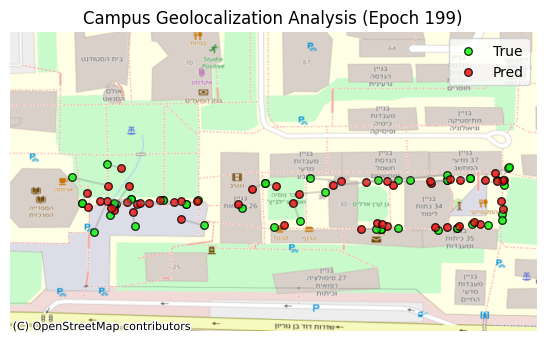

In [ ]:
log_error_map(real_preds, real_trues, epoch,num_points= 50)

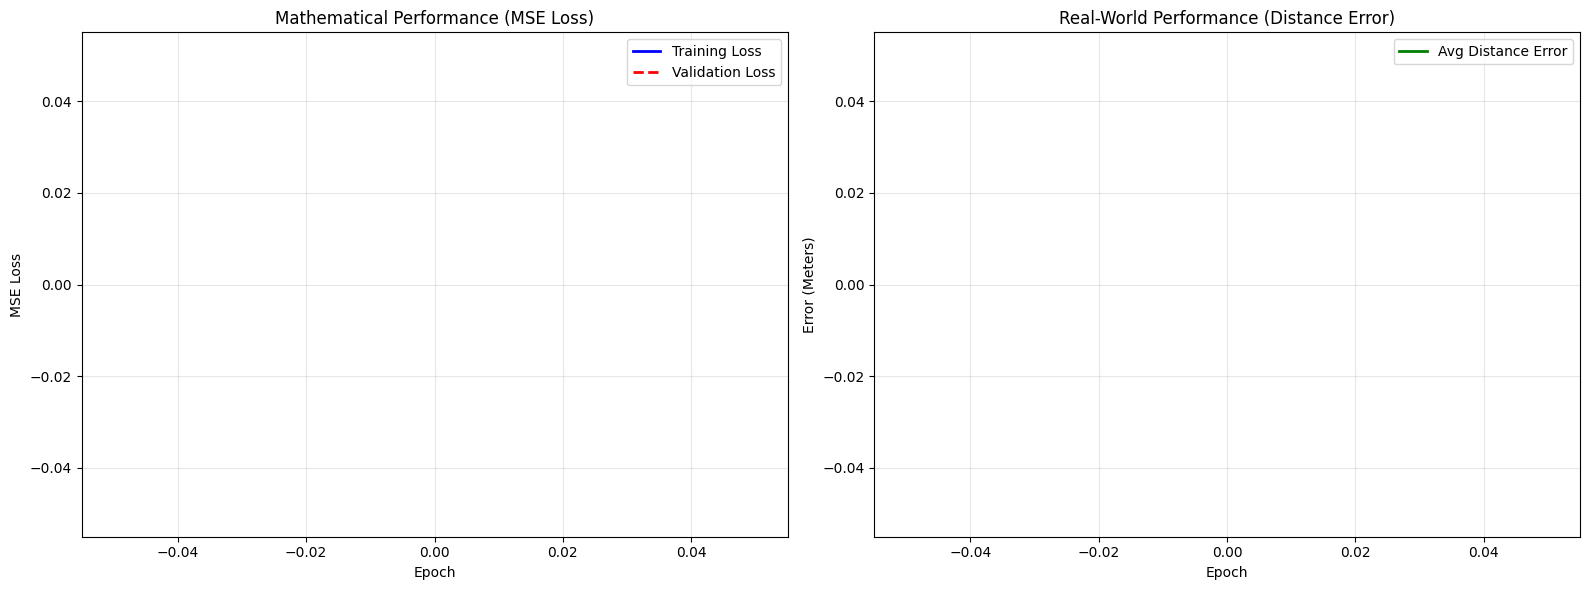


Training finished! Best Validation Error: 13.1 meters.
Model saved as 'geo_model.pth'


In [ ]:
# --- 9. SAVE THE MODEL & GENERATE PLOTS ---

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MSE Loss (Training vs Validation)
ax1.plot(train_losses, label="Training Loss", color="blue", linewidth=2)
ax1.plot(val_losses, label="Validation Loss", color="red", linestyle="--", linewidth=2)
ax1.set_title("Mathematical Performance (MSE Loss)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Physical Distance Error (Meters)
ax2.plot(val_dist_history, label="Avg Distance Error", color="green", linewidth=2)
ax2.set_title("Real-World Performance (Distance Error)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Error (Meters)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model weights
torch.save(model.state_dict(), "geo_model.pth")
print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
print("Model saved as 'geo_model.pth'")

In [ ]:
""" # Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet2().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}") """

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\013ri\AppData\Local\Temp\ipykernel_15020\333207449.py:1: SyntaxWarning: invalid escape sequence '\p'
  """ # Check if GPU is available, otherwise use CPU


' # Check if GPU is available, otherwise use CPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nSCALER_PATH = \'coordinate_scaler.pkl\'\nMODEL_WEIGHTS_PATH = \'geo_model.pth\'\n\n# Loading Model and Scaler\n# Initialize the model architecture and move to the device (GPU/CPU)\nmodel = ConvNet2().to(device)\n\n# Load the trained weights from the .pth file\nmodel.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))\n\n# Set the model to evaluation mode (disables Dropout and Batchnorm layers)\nmodel.eval()\n\n# Load the MinMaxScaler used during training to reverse the normalization\nscaler = joblib.load(SCALER_PATH)\n\n# Image Preprocessing Function\ndef predict_location(image_path):\n\n    # Load the image and ensure it is in RGB format\n    img = Image.open(image_path).convert(\'RGB\')\n\n    # Apply the same validation transforms (No augmentations here!)\n    preprocess = T.Compose([\n        T.Resize(256),\n        T.CenterCrop(256),\n        T.ToTensor(),\n        